In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

data_path = 'files_to_analyze'
output_path = 'output'

In [6]:
def pickle_csv_dataset(dataset, csv_paths):
    
    # Gather session_info from the first CSV of a dataset
    first_csv = csv_paths[0]
    session_id = None
    with open(first_csv, 'r') as file:
        lines = file.readlines() # load .csv data lines into memory

        # load desired session parameters
        session_id = float(next(line.split(',')[1] for line in lines if line.startswith('Session #,')))
        num_channels = float(next(line.split(',')[1] for line in lines if line.startswith('# of Channels,')))
        scan_rate = float(next(line.split(',')[1] for line in lines if line.startswith('Scan Rate (Hz),')))
        num_samples = float(next(line.split(',')[1] for line in lines if line.startswith('Samples/Channel,')))
        
        stim_duration = float(next(line.split(',')[1] for line in lines if line.startswith('Stimulus duration (ms),')))
        stim_interval = float(next(line.split(',')[1] for line in lines if line.startswith('Inter-Stim delay (sec),')))
        
        emg_amp_gains = []
        for line in lines:
            if line.startswith('EMG amp gain ch'):
                emg_amp_gains.append(int(float(line.split(',')[1])))

    # Create a dictionary to store the session data
    session_data = {
        'session_info': {
            'session_name' : dataset,
            'num_channels': int(num_channels),
            'scan_rate': int(scan_rate),
            'num_samples': int(num_samples),
            'stim_duration' : stim_duration,
            'stim_interval' : stim_interval,
            'emg_amp_gains': emg_amp_gains
        },
        'recordings': []
    }

    # Process each recording for stimulus and EMG data
    unsaved_data_files = [] # List of data files with flagged errors.
    for recording_file in csv_paths:  # Replace with your list of recording files
        with open(recording_file, 'r') as file:
            lines = file.readlines() # load CSV lines into memory.
            test_session_id = float(next(line.split(',')[1] for line in lines if line.startswith('Session #,')))
            
            
            if test_session_id != session_id: # If a second session's file is detected
                unsaved_data_files.append(recording_file)
                continue
        
            # Extract Stimulus Value (in volts)
            stimulus_v = float(next(line.split(',')[1] for line in lines if line.startswith('Stimulus Value (V),')))

            # Extract EMG "Recorded Data (mV)"
            start_index = None
            data_lines = []
            for i, line in enumerate(lines):
                if line.startswith("Recorded Data (mV),"):
                    start_index = i + 1
                elif start_index is not None:
                    data_lines.append(line.strip())
                    if line.strip() == "":
                        break
            data_array = [float(value) for value in data_lines] # this is the raw EMG data array in mV.

            # Append the recording data of this CSV to the session_data
            session_data['recordings'].append({
                'stimulus_v': stimulus_v,
                'data_array': data_array
            })
                

    # Check for unsaved files with errors.
    if len(unsaved_data_files) > 0:
        print(f'>! Error: multiple recording sessions detected in {dataset}.')
        print('\tData from the following files were not recorded to the session data file:')
        for file in unsaved_data_files:
            print(f'\t\t{file}')
        pass
    
    # Save the session data to its own pickle file
    save_name = dataset + '_data.pickle'
    with open(os.path.join(output_path, save_name), 'wb') as pickle_file:
        pickle.dump(session_data, pickle_file)

    # Return the number of CSV files attempted and successfully processed.
    num_csvs = len(csv_paths)
    num_csv_success = len(csv_paths) - len(unsaved_data_files)
    return num_csvs, num_csv_success

In [7]:
# Process files_to_analyze into Pickle files
datasets = [dir for dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, dir))] # list all datasets in "files_to_analyze" folder
print(f'Datasets to process: {datasets}')

# Create a pickle file for each dataset in files_to_analyze
for dataset in datasets:
    dataset_path = os.path.join(data_path, dataset)#.replace('\\', '/')
    
    csv_regex = re.compile(r'.*\.csv$') #regex to match CSV files only.
    csv_names = [item for item in os.listdir(dataset_path) if csv_regex.match(item)] #list of CSV filenames in dataset_path.
    csv_paths = [os.path.join(dataset_path, csv_name) for csv_name in csv_names]

    # check if there are CSVs in this dataset.
    if len(csv_paths) <= 0:
        print(f'>! Error: no CSV files detected in "{dataset}." Make sure you converted STMs to CSVs.')
        continue

    # Call function to extract dataset CSVs into a pickle file.
    num_csvs, num_csv_success = pickle_csv_dataset(dataset, csv_paths)
    print(f'> {num_csv_success} of {num_csvs} CSVs processed from dataset "{dataset}".')

print('Processing complete.')

#institute checks for:
    #has any CSVs -- forgot to convert?
#then extract session info from first file (EMG amp gains, scan rate)

Datasets to process: ['040224rec1', '040224rec14', '040224rec15', '040224rec16a', '040224rec16b', '040224rec3', '040224rec4', '040224rec5', '040224rec6', '040224rec7']
> 34 of 34 CSVs processed from dataset "040224rec1".
> 39 of 39 CSVs processed from dataset "040224rec14".
> 59 of 59 CSVs processed from dataset "040224rec15".
> 51 of 51 CSVs processed from dataset "040224rec16a".
> 22 of 22 CSVs processed from dataset "040224rec16b".
> 55 of 55 CSVs processed from dataset "040224rec3".
> 41 of 41 CSVs processed from dataset "040224rec4".
> 76 of 76 CSVs processed from dataset "040224rec5".
> 74 of 74 CSVs processed from dataset "040224rec6".
> 77 of 77 CSVs processed from dataset "040224rec7".
Processing complete.


In [26]:
#Load test_data pickle
import pickle

pickled_test_data = 'output/040224rec1_data.pickle'

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']

session_name = session_info['session_name']
num_channels = session_info['num_channels']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
stim_duration = session_info['stim_duration']
stim_interval = session_info['stim_interval']
emg_amp_gains = session_info['emg_amp_gains']

print(f"Session Name: {session_name}")
print(f"# of Channels: {num_channels}")
print(f"Scan rate (Hz): {scan_rate}")
print(f"Samples/Channel: {num_samples}")
print(f"Stimulus duration (ms): {stim_duration}")
print(f"Stimulus interval (s): {stim_interval}")
print(f"EMG amp gains: {emg_amp_gains}")

# Access recordings
recordings = session_data['recordings']
# for recording in recordings:
#     stimulus_v = recording['stimulus_v']
#     data_array = recording['data_array']
#     print(f"Stimulus Voltage: {stimulus_v}")
#     print(f"Data array length: {len(data_array)}")

Session Name: 040224rec1
# of Channels: 1
Scan rate (Hz): 10000
Samples/Channel: 10510
Stimulus duration (ms): 0.2
Stimulus interval (s): 10.0
EMG amp gains: [500, 500, 500, 500, 500, 500]


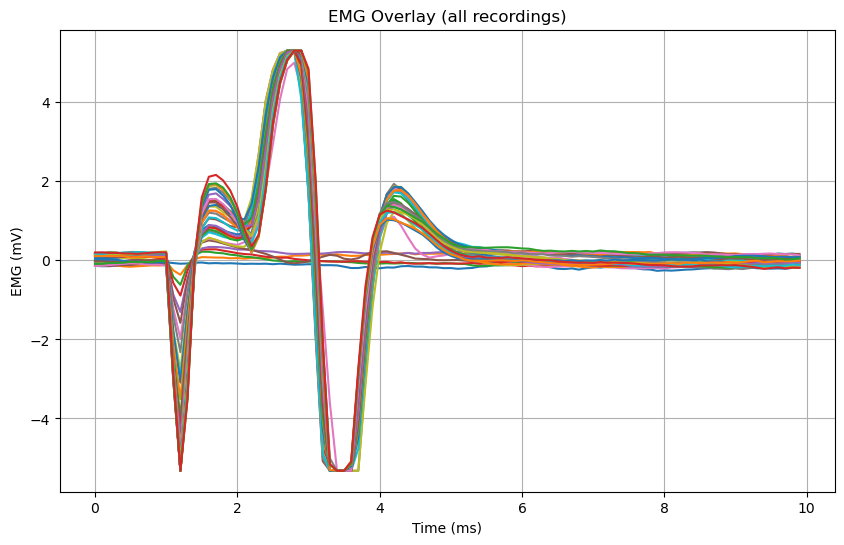

In [27]:
# Plot all recording EMGs

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Calculate time values based on the scan rate
time_values_ms = np.arange(num_samples) * 1000 / scan_rate  # Time values in milliseconds

# Determine the number of samples for the first 10ms
time_window_ms = 10  # Time window in milliseconds
num_samples_time_window = int(time_window_ms * scan_rate / 1000)  # Convert time window to number of samples

# Slice the time array for the time window
time_window_ms = time_values_ms[:num_samples_time_window]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the EMG arrays without stacking, only for the first 10ms
for recording in recordings:
    ax.plot(time_window_ms, recording['data_array'][:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")

# Set labels and title
ax.set_xlabel('Time (ms)')
ax.set_ylabel('EMG (mV)')
ax.set_title('EMG Overlay (all recordings)')
ax.grid(True)

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


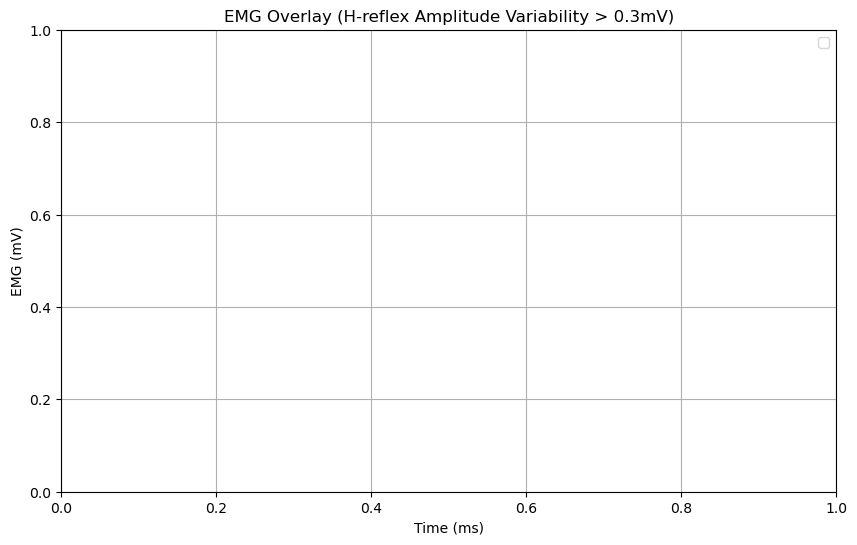

In [18]:
#Plot possible H-reflex 

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Calculate time values based on the scan rate
time_values_ms = np.arange(num_samples) * 1000 / scan_rate  # Time values in milliseconds

# Determine the number of samples for the first 10ms
time_window_ms = 10  # Time window in milliseconds
num_samples_time_window = int(time_window_ms * scan_rate / 1000)  # Convert time window to number of samples

# Slice the time array for the time window
time_window_ms = time_values_ms[:num_samples_time_window]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the EMG arrays without stacking, only for the first 10ms
for recording in recordings:
    data_window = recording['data_array'][int(5.5 * scan_rate / 1000):int(10 * scan_rate / 1000)]
    if max(data_window) - min(data_window) > 0.3:  # Check amplitude variation within 5-10ms window
        ax.plot(time_window_ms, recording['data_array'][:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")

# Set labels and title
ax.set_xlabel('Time (ms)')
ax.set_ylabel('EMG (mV)')
ax.set_title('EMG Overlay (H-reflex Amplitude Variability > 0.3mV)')
ax.grid(True)

# Add legend
ax.legend()

# Show the plot
plt.show()
